# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.7.3-alpha.new.202.203.206'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
187018,2020-08-20,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187019,2020-08-21,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187020,2020-08-22,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187021,2020-08-23,14,11,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187022,2020-08-24,14,11,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
187018,2020-08-20,Colombia,Vichada,14,9,0,5
187019,2020-08-21,Colombia,Vichada,14,9,0,5
187020,2020-08-22,Colombia,Vichada,14,9,0,5
187021,2020-08-23,Colombia,Vichada,14,3,0,11
187022,2020-08-24,Colombia,Vichada,14,3,0,11


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
154,2020-08-20,18607,3447,348,14812
155,2020-08-21,18865,3406,350,15109
156,2020-08-22,19121,3362,350,15409
157,2020-08-23,19333,3421,350,15562
158,2020-08-24,19428,3350,352,15726


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-08-20,22663814,7397644,795636,14470534,0.017553,0.319243,0.052118
2020-08-21,22914783,7471930,800921,14641932,0.017476,0.319487,0.051864
2020-08-22,23170096,7506490,806215,14857391,0.017398,0.320616,0.051471
2020-08-23,23367876,7501487,809690,15056699,0.017325,0.322167,0.051032
2020-08-24,23373718,7504852,809760,15059106,0.017322,0.322138,0.051028


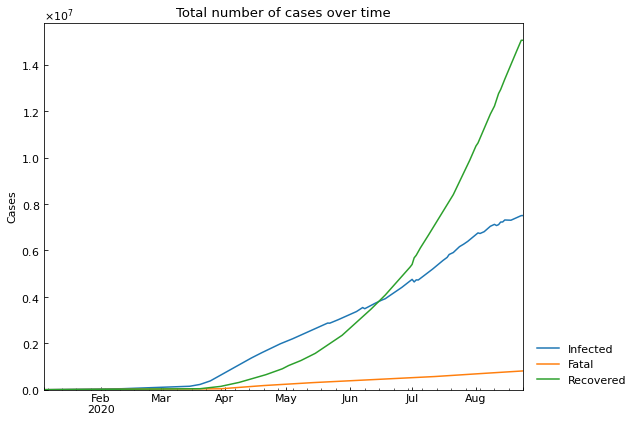

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
193,2020-08-20,59951,13541,1159,45251
194,2020-08-21,60984,13360,1174,46450
195,2020-08-22,61966,13177,1180,47609
196,2020-08-23,62710,12990,1189,48531
197,2020-08-24,63203,12693,1202,49308


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
191,2020-08-20,58501,12091,1144,45266
192,2020-08-21,59721,12099,1155,46467
193,2020-08-22,60733,11942,1169,47622
194,2020-08-23,61747,12021,1176,48550
195,2020-08-24,62507,11986,1181,49340


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
187018,2020-08-20,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187019,2020-08-21,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187020,2020-08-22,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187021,2020-08-23,14,11,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187022,2020-08-24,14,11,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
183450,COL,Colombia,Vichada,2020-08-20,107808
183451,COL,Colombia,Vichada,2020-08-21,107808
183452,COL,Colombia,Vichada,2020-08-22,107808
183453,COL,Colombia,Vichada,2020-08-23,107808
183454,COL,Colombia,Vichada,2020-08-24,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
187018,2020-08-20,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187019,2020-08-21,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187020,2020-08-22,14,5,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187021,2020-08-23,14,11,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
187022,2020-08-24,14,11,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
187018,2020-08-20,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
187019,2020-08-21,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
187020,2020-08-22,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
187021,2020-08-23,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
187022,2020-08-24,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
229,2020-08-20,1,1,1,0,0,1,1,3,2,2,1,30.56
230,2020-08-21,1,1,1,0,0,1,1,3,2,2,1,30.56
231,2020-08-22,1,1,1,0,0,1,1,3,2,2,1,30.56
232,2020-08-23,1,1,1,0,0,1,1,3,2,2,1,30.56
233,2020-08-24,1,1,1,0,0,1,1,3,2,2,1,30.56


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
229,2020-08-20,1,1,1,0,0,1,1,3,2,2,1,30.56
230,2020-08-21,1,1,1,0,0,1,1,3,2,2,1,30.56
231,2020-08-22,1,1,1,0,0,1,1,3,2,2,1,30.56
232,2020-08-23,1,1,1,0,0,1,1,3,2,2,1,30.56
233,2020-08-24,1,1,1,0,0,1,1,3,2,2,1,30.56


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

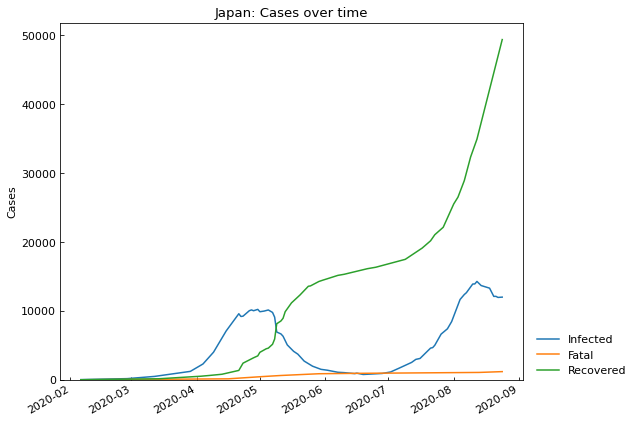

,Date,Confirmed,Infected,Fatal,Recovered
191,2020-08-20,58501,12091,1144,45266
192,2020-08-21,59721,12099,1155,46467
193,2020-08-22,60733,11942,1169,47622
194,2020-08-23,61747,12021,1176,48550
195,2020-08-24,62507,11986,1181,49340


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

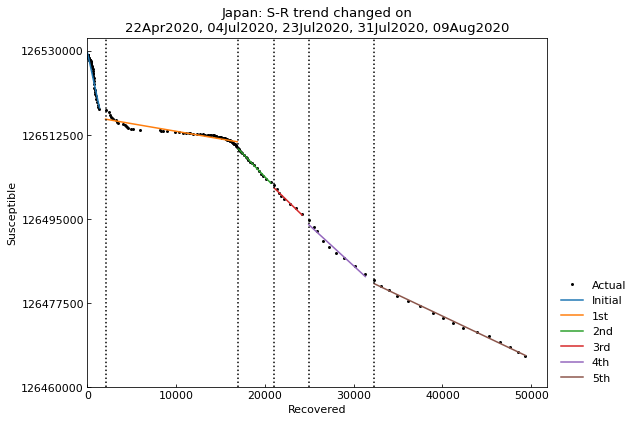

,Type,Start,End,Population
1st,Past,22Apr2020,03Jul2020,126529100
2nd,Past,04Jul2020,22Jul2020,126529100
3rd,Past,23Jul2020,30Jul2020,126529100
4th,Past,31Jul2020,08Aug2020,126529100
5th,Past,09Aug2020,24Aug2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	5th phase (09Aug2020 - 24Aug2020): finished 1291 trials in 1 min  0 sec

	3rd phase (23Jul2020 - 30Jul2020): finished  142 trials in 0 min  5 sec

	4th phase (31Jul2020 - 08Aug2020): finished 1356 trials in 1 min  0 sec

	1st phase (22Apr2020 - 03Jul2020): finished 1314 trials in 1 min  0 sec

	2nd phase (04Jul2020 - 22Jul2020): finished 1361 trials in 1 min  0 sec

Completed optimization. Total: 2 min  1 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/beta [day],alpha1 [-],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,22Apr2020,03Jul2020,126529100,SIR-F,0.36,0.089819,0.000318,0.008630,0.021460,480,1048,38,0.090,15,0.789734,1314,1 min 0 sec
2nd,Past,04Jul2020,22Jul2020,126529100,SIR-F,2.02,0.000938,0.000031,0.048202,0.023859,480,10652,6,0.001,13,0.038903,1361,1 min 0 sec
3rd,Past,23Jul2020,30Jul2020,126529100,SIR-F,2.00,0.001705,0.000093,0.043787,0.021754,480,3566,7,0.002,15,0.032375,142,0 min 5 sec
4th,Past,31Jul2020,08Aug2020,126529100,SIR-F,1.90,0.000771,0.000078,0.040979,0.021484,480,4298,8,0.001,15,0.037624,1356,1 min 0 sec
5th,Past,09Aug2020,24Aug2020,126529100,SIR-F,0.91,0.004517,0.000128,0.026449,0.028782,480,2611,12,0.005,11,0.042735,1291,1 min 0 sec


### Accuracy of estimation

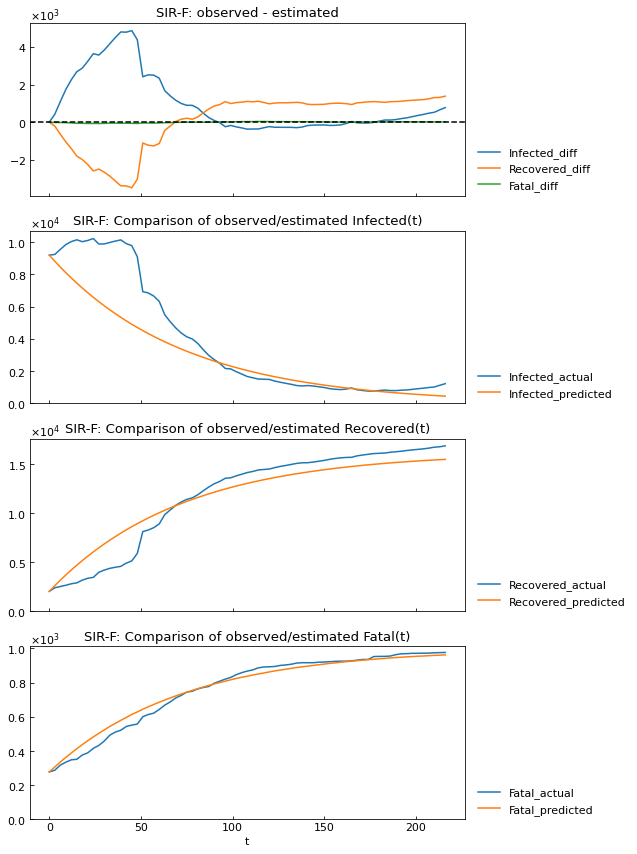

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.9

### Show parameter history

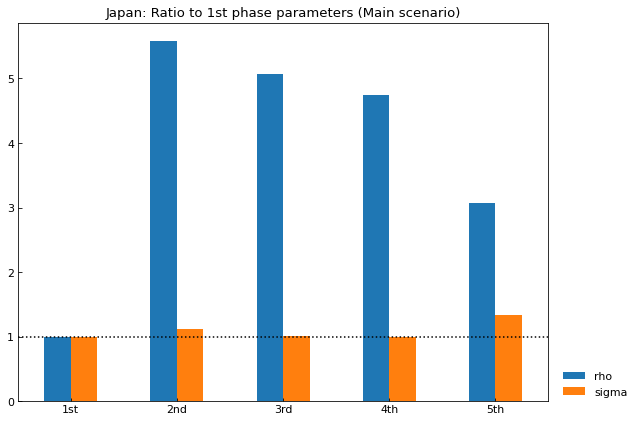

,1st,2nd,3rd,4th,5th
rho,1.0,5.585109,5.073571,4.748264,3.064629
sigma,1.0,1.111788,1.013688,1.001136,1.341213


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

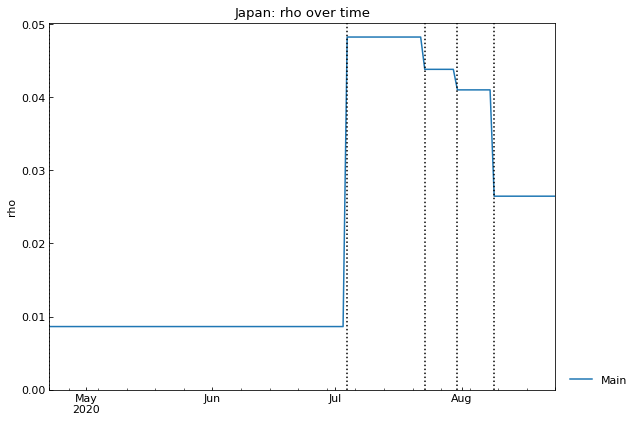

In [33]:
# version >= 2.7.3-alpha
_ = scenario.history(target="rho")

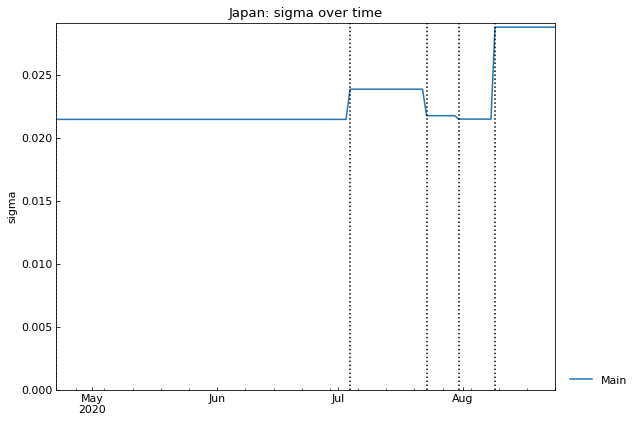

In [34]:
# version >= 2.7.3-alpha
_ = scenario.history(target="sigma")

### Show the history of reproduction number

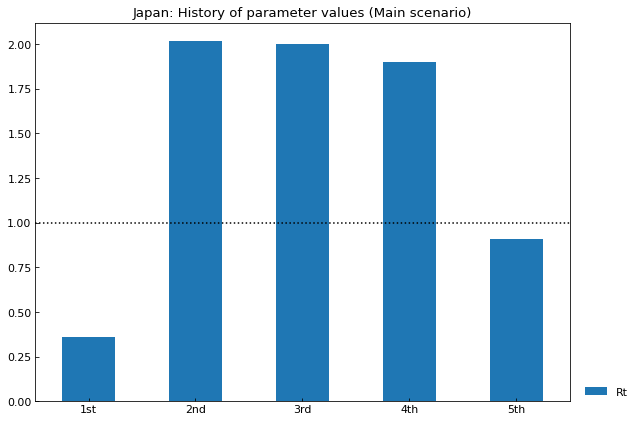

,1st,2nd,3rd,4th,5th
Rt,0.36,2.02,2.0,1.9,0.91


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

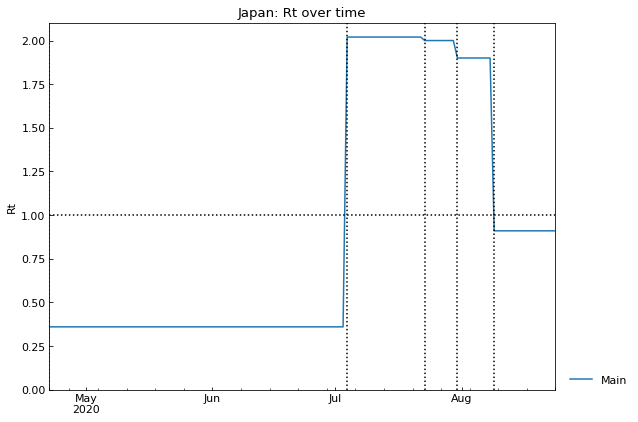

In [36]:
# version >= 2.7.3-alpha
_ = scenario.history(target="Rt")

### Simulate the number of cases

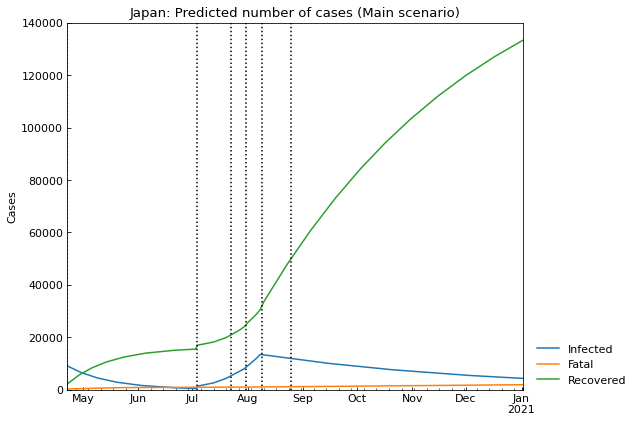

,Date,Confirmed,Fatal,Infected,Recovered
251,2020-12-29,138236,1895,4435,131906
252,2020-12-30,138586,1898,4400,132288
253,2020-12-31,138933,1901,4366,132666
254,2021-01-01,139279,1905,4332,133042
255,2021-01-02,139620,1908,4298,133414


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.028782469417489194

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.05756493883497839

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.36   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.02   
         3rd      Past  23Jul2020  30Jul2020   126529100  SIR-F  2.00   
         4th      Past  31Jul2020  08Aug2020   126529100  SIR-F  1.90   
         5th      Past  09Aug2020  24Aug2020   126529100  SIR-F  0.91   
         6th    Future  25Aug2020  01Jan2021   126529100  SIR-F  0.91   
Medicine 1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.36   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.02   
         3rd      Past  23Jul2020  30Jul2020   126529100  SIR-F  2.00   
         4th      Past  31Jul2020  08Aug2020   126529100  SIR-F  1.90   
         5th      Past  09Aug2020  24Aug2020   126529100  SIR-F  0.91   
         6th    Future  25Aug2020  24Sep2020   126529100  SIR-F  0.91   
         7th    Future  25Sep2020  01Jan2021   126529100  SIR-F  0.46   

                   theta     kappa       rho     sigma  tau  1/alpha2 [day]  \
Scenario Phase                                                                
Main     1st    0.089819  0.000318  0.008630  0.021460  480            1048   
         2nd    0.000938  0.000031  0.048202  0.023859  480           10652   
         3rd    0.001705  0.000093  0.043787  0.021754  480            3566   
         4th    0.000771  0.000078  0.040979  0.021484  480            4298   
         5th    0.004517  0.000128  0.026449  0.028782  480            2611   
         6th    0.004517  0.000128  0.026449  0.028782  480            2611   
Medicine 1st    0.089819  0.000318  0.008630  0.021460  480            1048   
         2nd    0.000938  0.000031  0.048202  0.023859  480           10652   
         3rd    0.001705  0.000093  0.043787  0.021754  480            3566   
         4th    0.000771  0.000078  0.040979  0.021484  480            4298   
         5th    0.004517  0.000128  0.026449  0.028782  480            2611   
         6th    0.004517  0.000128  0.026449  0.028782  480            2611   
         7th    0.004517  0.000128  0.026449  0.057565  480            2611   

                1/beta [day]  alpha1 [-]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                              
Main     1st              38       0.090             15   0.789734   1314   
         2nd               6       0.001             13  0.0389028   1361   
         3rd               7       0.002             15  0.0323755    142   
         4th               8       0.001             15   0.037624   1356   
         5th              12       0.005             11  0.0427347   1291   
         6th              12       0.005             11          -      -   
Medicine 1st              38       0.090             15   0.789734   1314   
         2nd               6       0.001             13  0.0389028   1361   
         3rd               7       0.002             15  0.0323755    142   
         4th               8       0.001             15   0.037624   1356   
         5th              12       0.005             11  0.0427347   1291   
         6th              12       0.005             11          -      -   
         7th              12       0.005              5          -      -   

                     Runtime  
Scenario Phase                
Main     1st    1 min  0 sec  
         2nd    1 min  0 sec  
         3rd    0 min  5 sec  
         4th    1 min  0 sec  
         5th    1 min  0 sec  
         6th               -  
Medicine 1st    1 min  0 sec  
         2nd    1 min  0 sec  
         3rd    0 min  5 sec  
         4th    1 min  0 sec  
         5th    1 min  0 sec  
         6th               -  
         7th               -

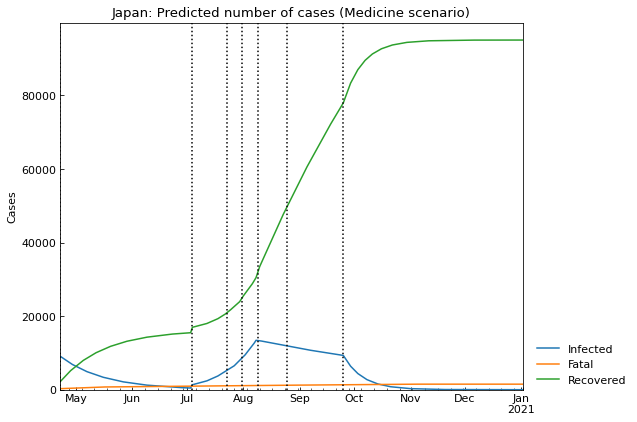

,Date,Confirmed,Fatal,Infected,Recovered
251,2020-12-29,96557,1505,1,95051
252,2020-12-30,96557,1505,1,95051
253,2020-12-31,96558,1505,1,95052
254,2021-01-01,96558,1505,1,95052
255,2021-01-02,96558,1505,1,95052


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,7th_Rt
Main,13431,08Aug2020,4298,1908,-
Medicine,13431,08Aug2020,1,1505,0.46


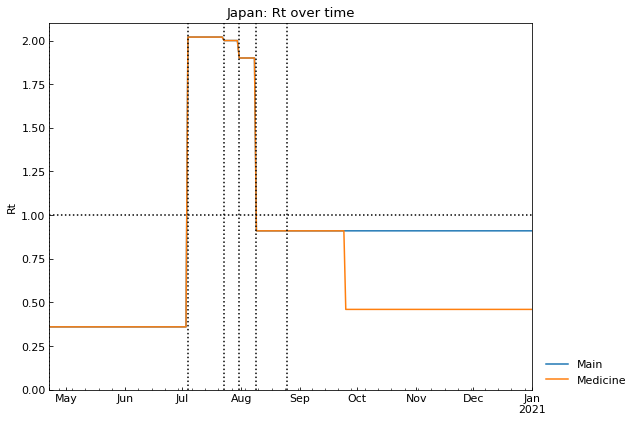

In [43]:
# version >= 2.7.3-alpha
_ = scenario.history(target="Rt")

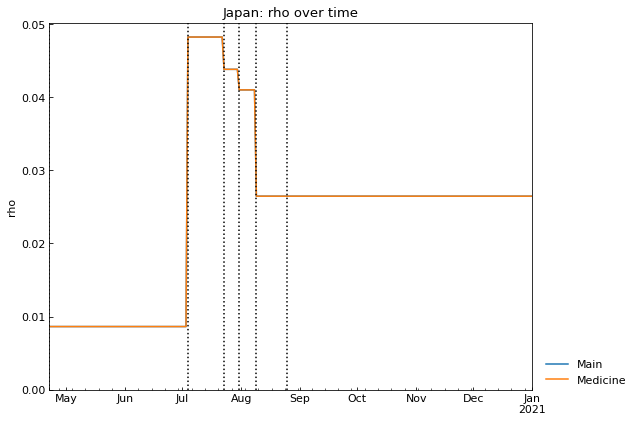

In [44]:
# version >= 2.7.3-alpha
_ = scenario.history(target="rho")

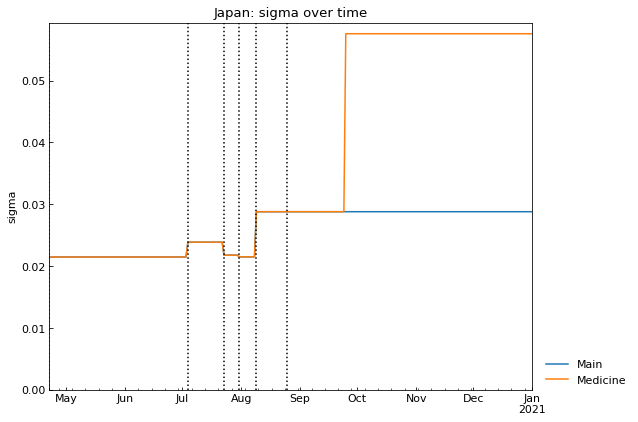

In [45]:
# version >= 2.7.3-alpha
_ = scenario.history(target="sigma")

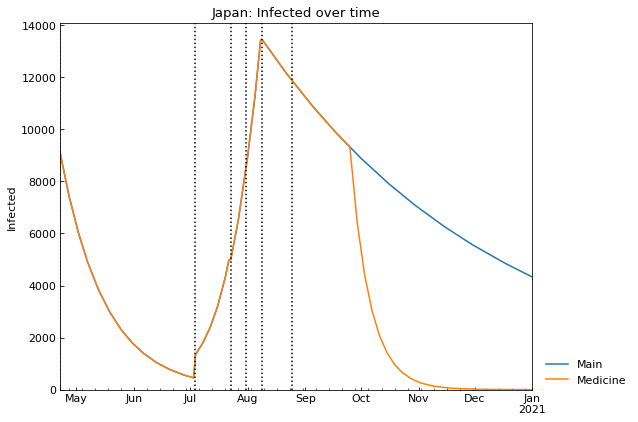

In [46]:
# version >= 2.7.3-alpha
_ = scenario.history(target="Infected")